<a href="https://colab.research.google.com/github/joaquinparodi/TP1-DATOS/blob/main/tp2orga_joaquin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
!pip install ptitprince
import ptitprince as pt
import pandas as pd
import numpy as np


     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for ptitprince: filename=ptitprince-0.2.5-cp36-none-any.whl size=8428 sha256=3a5c6b091ca3852fad426b2536bde6cd280d3d3ce8e72e810b3b8368ce64a498
  Stored in directory: /root/.cache/pip/wheels/fb/c1/75/2ef8da161053bdf8e03f9a360f426accd4fac1ddf7f6ed0029
Successfully built ptitprince


In [2]:
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
 
id='1MfnxlPGSmr-i1up_2iKCkrBIMcDHomnK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.csv')

In [6]:
id='1kZt5ZN2eAyeNEIWLh6lGckgyDIxpHN4f'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [7]:
test=pd.read_csv('test.csv')

In [8]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

In [9]:
class Modelo():
  def __init__(self ):
    pass



  def splitTrainTarget(self,entrenamientoFeatureTarget):
    #separo  mi dataframe en X= feature engineri e y= target
    X,y=entrenamientoFeatureTarget.iloc[:,1:-1], entrenamientoFeatureTarget.iloc[:,-1]
    print("las columnas del train son {} y del target son  {}".format(X.columns , y.name ))
    return X,y

  def SplitTrainTest(self,X,y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

    return X_train, X_test, y_train, y_test


  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(X_test)
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
     preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
     rmse = np.sqrt(mean_squared_error(y_test, preds))
     print("RMSE: %f" % (rmse)) 



  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
    listaColumnas=dfTestFeature.columns.to_list()
    listaColumnas.remove('Opportunity_ID')
    dfFeaturestest=dfFeaturestest[listaColumnas] 
    #se elemina esa columan porque sino hay overfittin
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  

  

  def agregarTargetDfOriginal(self,entrenamiento,df):
    #df es un dataframe ya agregado con features nuevos
    #entrenamiento es el dataframe orginal sin procesar
    target=entrenamiento[(entrenamiento['Stage']=='Closed Lost') | (entrenamiento['Stage']=='Closed Won')]
    target=target[['Opportunity_ID','Stage']].groupby(['Opportunity_ID','Stage']).agg(total=('Stage','count')).reset_index()[['Opportunity_ID','Stage']]
      
    entrenamiento=pd.merge(df,target,on="Opportunity_ID",how="inner") 
    df=entrenamiento.replace("Closed Lost", "0")
    df=df.replace("Closed Won", "1")
  
    return df

  #feature engnerie
  def featureEngeenier(self,df):
    #agregamos fecha 
    df['Month']=pd.to_datetime(df['Month'])
    df['anio']=df['Month'].dt.year
    df['mes']=df['Month'].dt.month
    #agregamos columna totalamount
    totalAmount=df.groupby(['Opportunity_ID' ]).agg(totalamount=('Total_Amount','sum'))
    #agregamos total trf
    totalTrf=df.groupby(['Opportunity_ID' ]).agg(totalTrf=('TRF','sum'))
    dfFeatureNew=pd.merge(totalAmount,totalTrf,on="Opportunity_ID",how="inner").reset_index()

    df=dfFeatureNew[['Opportunity_ID','totalamount','totalTrf']]
    
    return df


  def formarDfKaggle(self,testWithFeature,preds ):
    dfkaggle = pd.DataFrame( preds)
    dfkaggle['Opportunity_ID']=testWithFeature['Opportunity_ID']
    dfkaggle.columns=['Target','Opportunity_ID']
    dfkaggle=dfkaggle[['Opportunity_ID','Target']]
    
    from google.colab import files
    dfkaggle.to_csv('dfKaggle.csv', index=False) 
    files.download('dfKaggle.csv')
   
  def featureImportancia(self,X_train):
    # Gini importance
    self.modelo.feature_importances_
    plt.bar(X_train.columns, self.modelo.feature_importances_)
    plt.xlabel('Features')
    plt.ylabel('Importancia')
    plt.title('Importancia Features con RF')
    plt.show()


In [10]:
class RandomForestRegre(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= RandomForestRegressor(random_state=1,n_estimators=20)


class xgbosst(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 10)
  


  # este polimorfismo es porque pedia el xgboost que y_train sea de tipo int
  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(X_test)
     
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
    #aca la diferencia es que ytrain debe ser entero
     
    preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))

  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
    listaColumnas=dfTestFeature.columns.to_list()
    listaColumnas.remove('Opportunity_ID')
    dfFeaturestest=dfFeaturestest[listaColumnas] 
    #se elemina esa columan porque sino hay overfittin
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  


In [11]:
#1)Apertura
entrenamiento = pd.read_csv('data.csv')
 

In [12]:
random_state=1
n_estimators=20
#aca agregamos los hiperparametros que estamos probando
Hiperparametros=[random_state ,n_estimators ]
#por ahora no se usan los hirparametros, se setea dentro de las clase estos,
#pero la idea es que se pueda setear desde afuera para probar

In [13]:
modelos={
         'ramdomForest': RandomForestRegre(Hiperparametros),
         'xgboost':xgbosst(Hiperparametros)
}

In [14]:


modelo=modelos.get('xgboost')
#cargamos el modelo 
modelo=modelo
#hacemos feature engierine sobre el df original
dfFeature=modelo.featureEngeenier(entrenamiento)
dfFeature.head()
#le agregamos el target
dfFeatureWithTarget=modelo.agregarTargetDfOriginal(entrenamiento,dfFeature)
dfFeatureWithTarget.head()

,Opportunity_ID,totalamount,totalTrf,Stage
0,0,5272800.0,10,0
1,1,48230.0,0,1
2,2,83865.6,0,1
3,3,7421881.5,14,0
4,4,13357192.5,25,0


aca vamos a entrenar y testear con el mismo dataframe original, asi vemos
que error nos da

In [15]:
X,y=modelo.splitTrainTarget(dfFeatureWithTarget)

las columnas del train son Index(['totalamount', 'totalTrf'], dtype='object') y del target son  Stage


In [16]:
#separamos para entrenar (X_train, y_train) y para predecir (y_train) y su prediccion real(y_test)
X_train, X_test, y_train, y_test=modelo.SplitTrainTest(X,y)

In [17]:
#entrenamo y predecimos, y comparamos con el valor real y vemos su error
modelo.errorSetEntrenamiento(  X_train,y_train,X_test,y_test) 
     

RMSE: 0.455257


aca vamos a entrenar y predecir con el test para subir a kaggle

In [18]:
test=pd.read_csv('test.csv')
dfTestFeature=modelo.featureEngeenier(test)
dfTestFeature.head()

,Opportunity_ID,totalamount,totalTrf
0,10689,367419.0,0
1,10690,757783.5,1
2,10691,21037.5,0
3,10692,2169106.5,6
4,10693,5752.5,0


In [19]:
prediccion=modelo.entrenarYPredecirWithTest(X_train,y_train,dfTestFeature)
prediccion

array([0.534768  , 0.39591077, 0.6522572 , ..., 0.6522572 , 0.55602616,
       0.3828056 ], dtype=float32)

In [20]:
modelo.formarDfKaggle(dfTestFeature,prediccion)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

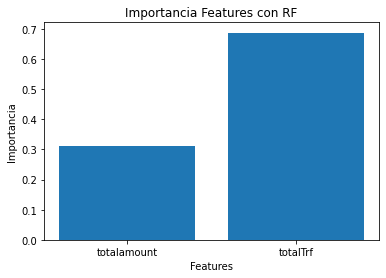

In [21]:
modelo.featureImportancia( X_train)